In [1]:
import os
os.environ["SPS_HOME"] = "/Users/fpetri/packages/fsps" 

In [2]:
import numpy as np
import lbg_forecast.nz as nz
import lbg_forecast.emulator as em
import lbg_forecast.hyperparameters as hyp
import lbg_forecast.population_model as pop
import lbg_forecast.priors_mass_func as pr
import matplotlib.pyplot as plt
import scipy as sc

In [3]:
# initalise fsps emulator
model = em.fsps_emulator("/Users/fpetri/repos/LBGforecast")

In [4]:
# nz histogram parameters
dz = 0.1
minz = 0.0
maxz = 7.0

bins = np.arange(minz, maxz, dz)

In [5]:
bounds = hyp.hyperparameter_tighter()
nhypersamples = 20
hyperparameter_samples = np.vsplit(hyp.sample_prior_parameters(nhypersamples, bounds[0], bounds[1]), nhypersamples)

In [6]:
prior_data = pr.preload_prior_data(zmax=7.0)

/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/speculator/speculator.py:709: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-08 to the diagonal
  warnings.warn(
/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/speculator/speculator.py:709: RuntimeWarning: overflow encountered in exp
  layers.append((self.betas_[i] + (1.-self.betas_[i])*1./(1.+np.exp(-self.alphas_[i]*act[-1])))*act[-1])
/Users/fpetri/anaconda3/envs/tf_env/lib/python3.11/site-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d.,

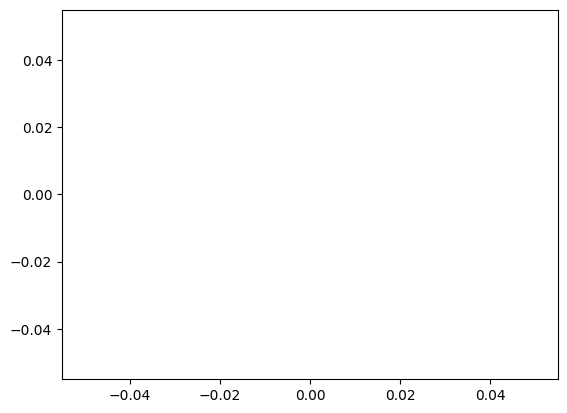

In [7]:
nsamples = 200000
nzs = []
spsp = []
for row in hyperparameter_samples:
    sps_params = pop.generate_sps_parameters(nsamples, row[0], prior_data, uniform_redshift_mass=False, uniform_logf=False)
    lbg_nzs = nz.simulate_nzs(sps_params, model, 1000)
    nzs.append(lbg_nzs)
    spsp.append(sps_params)

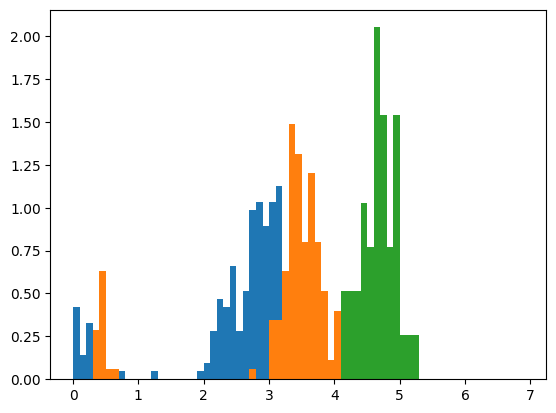

In [8]:
indx = 0
hist = plt.hist(nzs[indx][0], density=True, bins=bins)
hist = plt.hist(nzs[indx][1], density=True, bins=bins)
hist = plt.hist(nzs[indx][2], density=True, bins=bins)

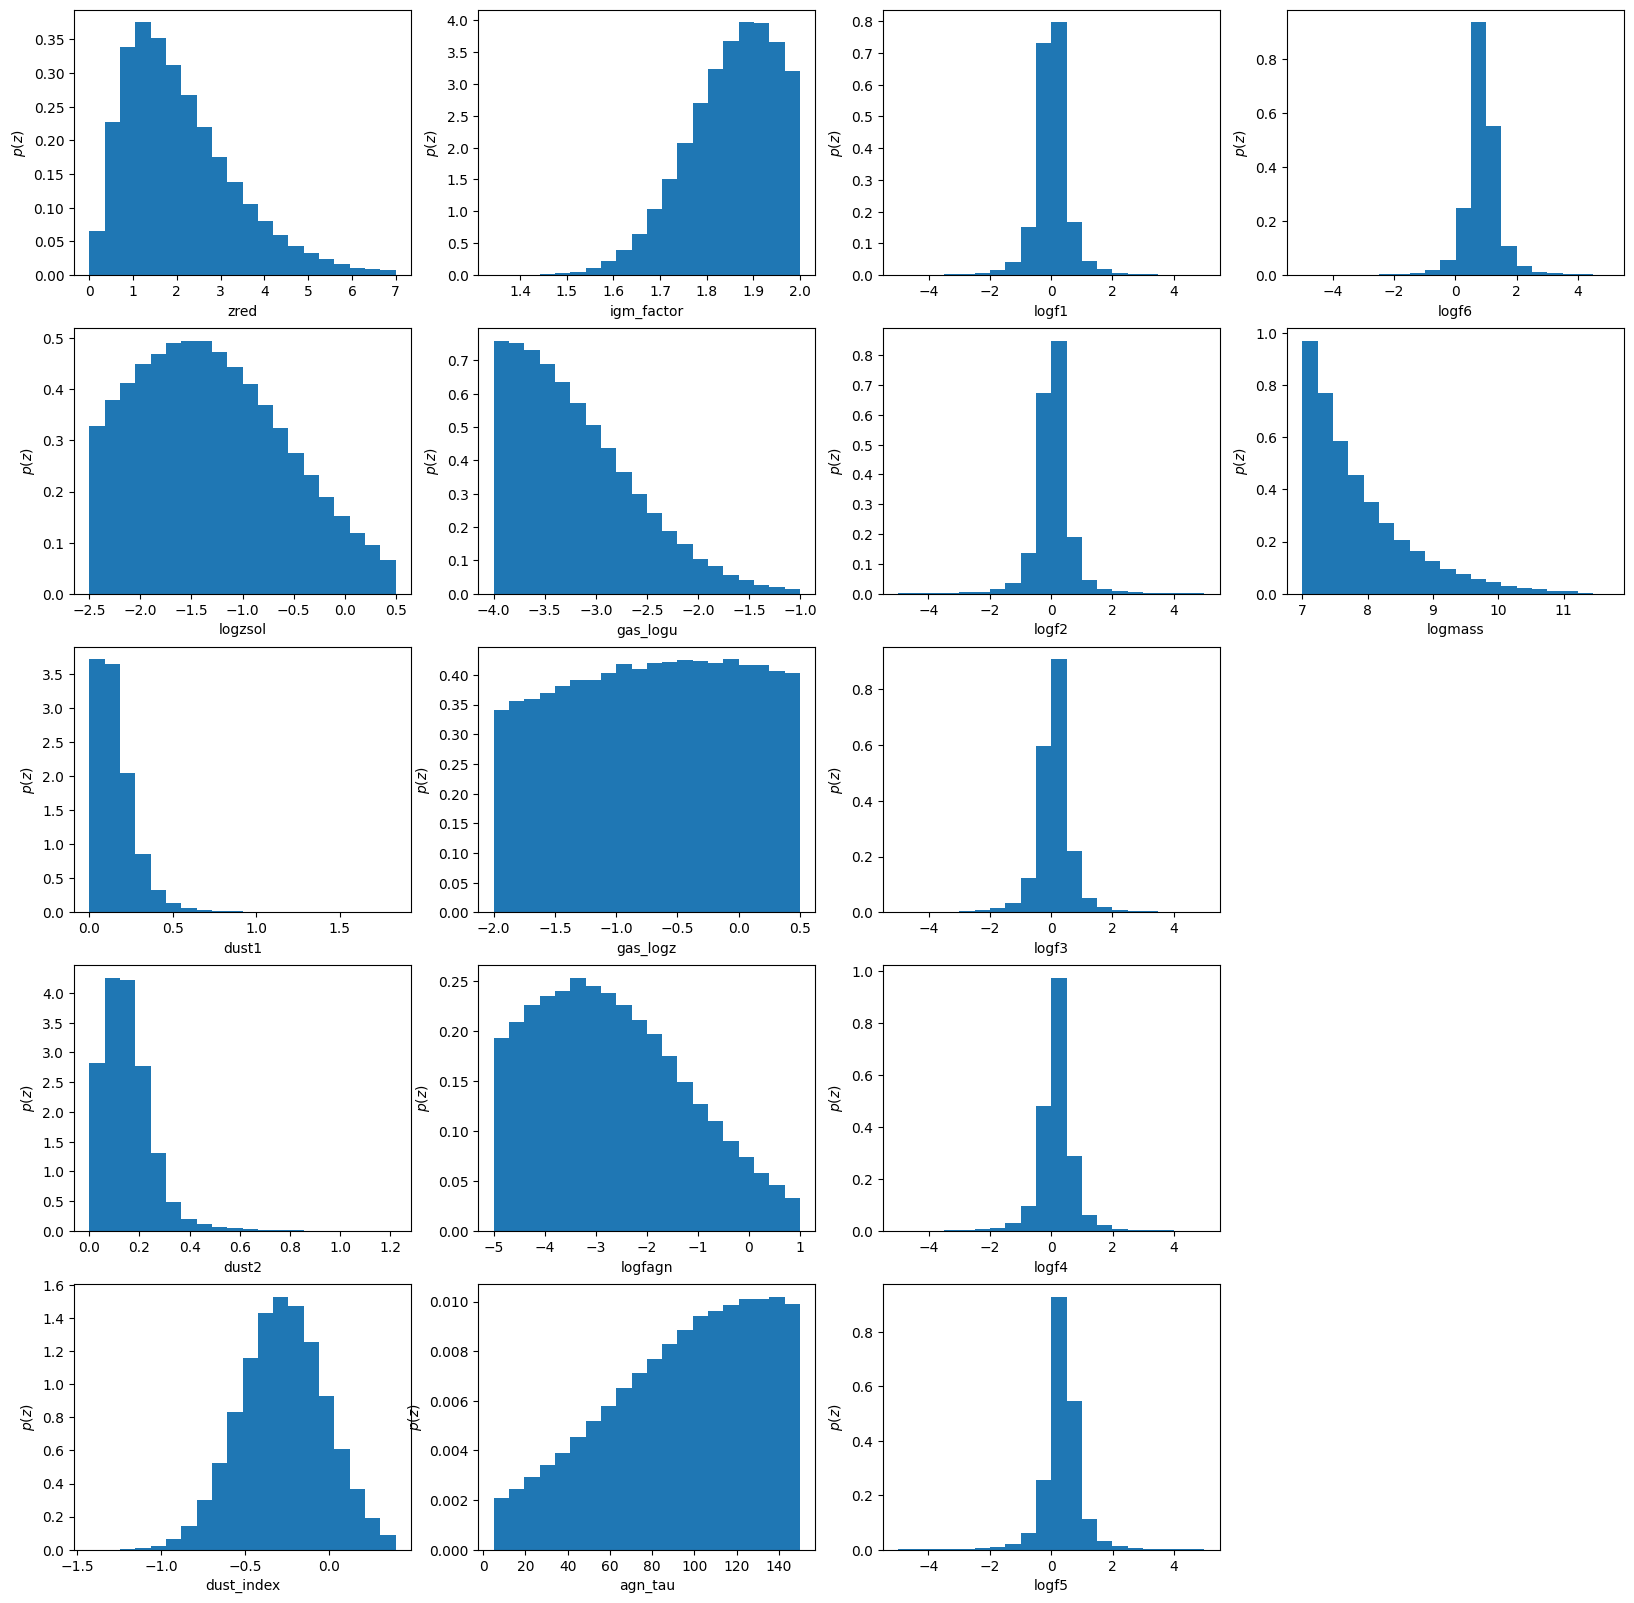

In [9]:
pop.plot_galaxy_population(spsp[indx])

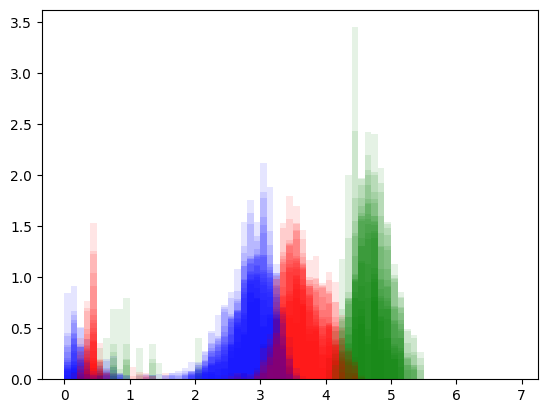

In [10]:
for ind in range(nhypersamples):
    hist = plt.hist(nzs[ind][0], density=True, bins=bins, alpha = 0.1, color='blue')
    hist = plt.hist(nzs[ind][1], density=True, bins=bins, alpha = 0.1, color='red')
    hist = plt.hist(nzs[ind][2], density=True, bins=bins, alpha = 0.1, color='green')

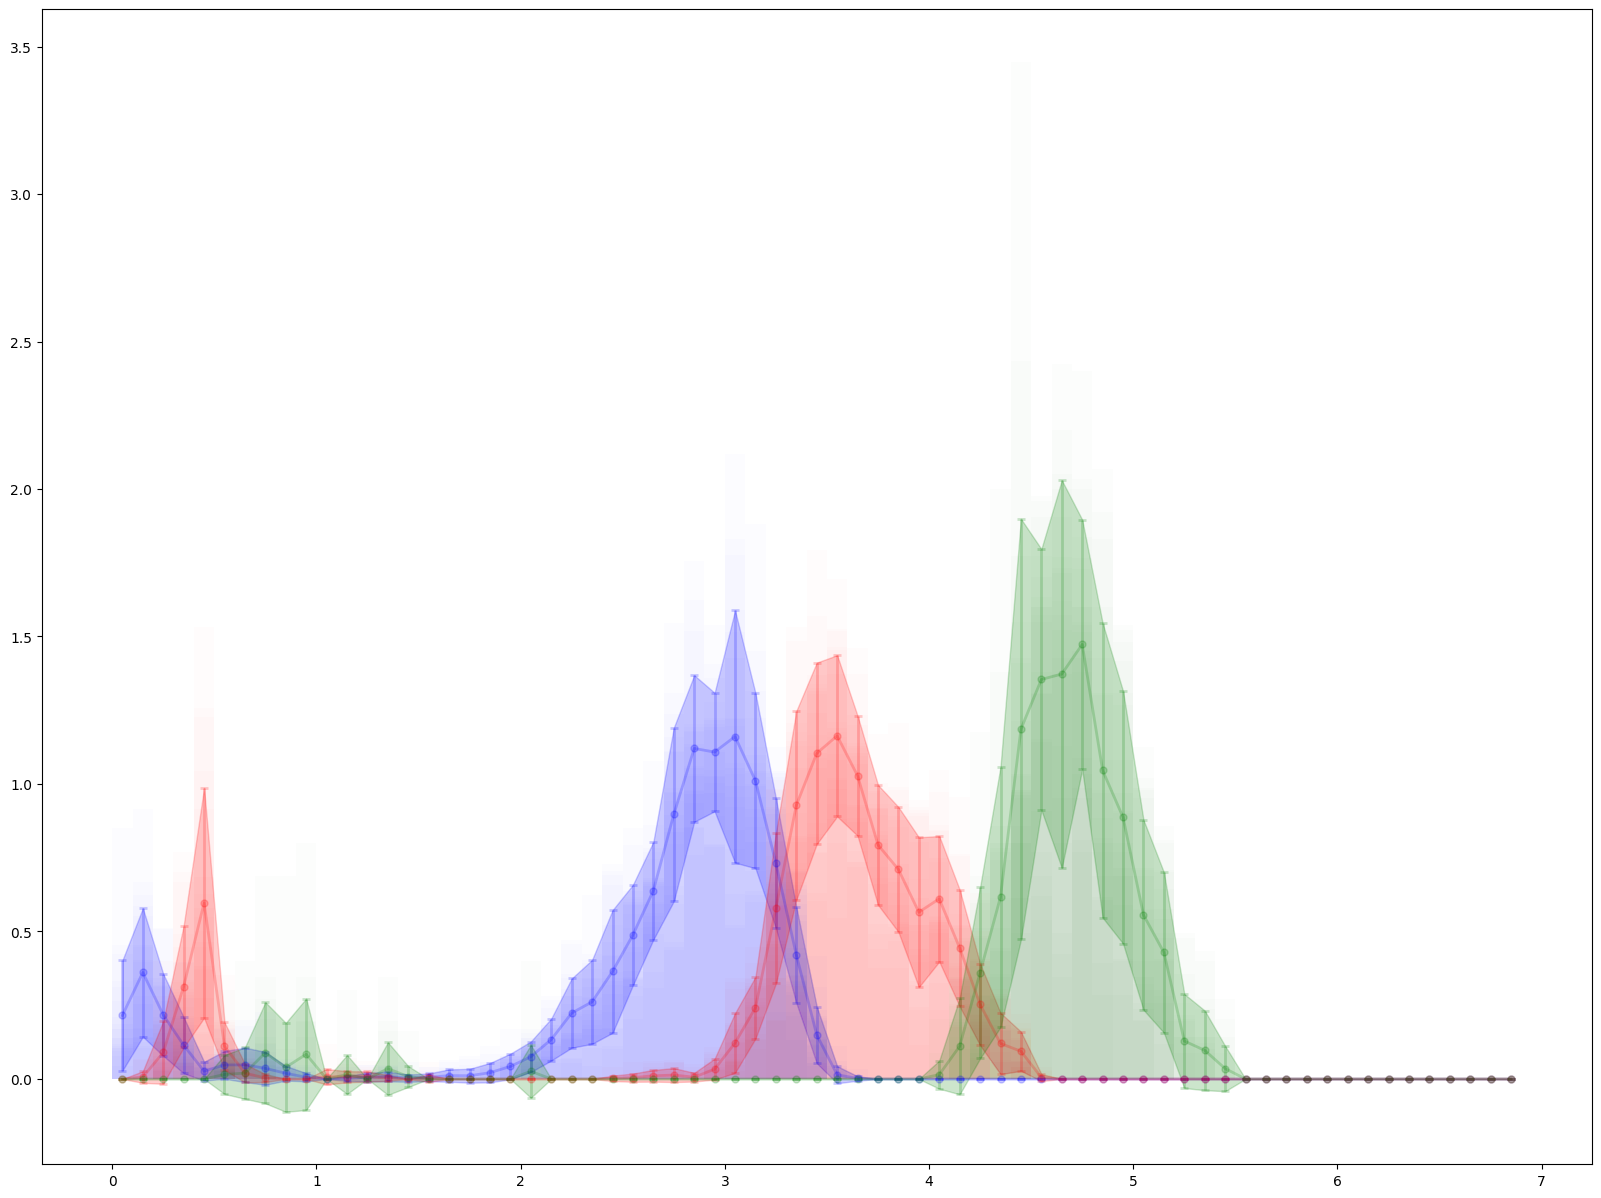

In [11]:
fig1, axes = plt.subplots(1, 1, figsize=(20,15), sharex=False, sharey=False)

colours = ['blue', 'red', 'green']
for drop in range(3):

    values = []
    x = []
    for ind in range(nhypersamples):
        hist = axes.hist(nzs[ind][drop], density=True, bins=bins, alpha = 0.01, color=colours[drop])
        values.append(hist[0])
        x.append(hist[1])

    values = np.hstack((np.array(values)))
    x = np.array(x)
    x = np.hstack(((x+0.05)[:,:-1]))


    bin_means, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'mean', bins=bins)
    bin_std, bin_edges, binnumber = sc.stats.binned_statistic(x, values, 'std', bins=bins)
    bin_width = (bin_edges[1] - bin_edges[0])
    bin_centers = bin_edges[1:] - bin_width/2

    axes.errorbar(bin_centers, bin_means, bin_std, alpha=0.2, ms=10, marker=".", elinewidth=2, capsize=3, capthick=2, lw=2, color=colours[drop])
    axes.fill_between(bin_centers, bin_means-bin_std, bin_means+bin_std, alpha=0.2, color=colours[drop])

[0.107981220657277, 0.2159090909090909, 0.13839285714285715, 0.06920415224913495, 0.18433179723502305, 0.10674157303370786, 0.040955631399317405, 0.11538461538461539, 0.16862745098039217, 0.20261437908496732, 0.05226480836236934, 0.06818181818181818, 0.059375, 0.10037174721189591, 0.15425531914893617, 0.18543046357615894, 0.04177545691906005, 0.10126582278481013, 0.0700280112044818, 0.03611111111111111]
[0.10285714285714286, 0.2866666666666667, 0.09340659340659341, 0.0970464135021097, 0.20245398773006135, 0.1437908496732026, 0.04, 0.08139534883720931, 0.1087866108786611, 0.26900584795321636, 0.031496062992125984, 0.10628019323671498, 0.0668693009118541, 0.05351170568561873, 0.12101910828025478, 0.25874125874125875, 0.02631578947368421, 0.11764705882352941, 0.0782312925170068, 0.04878048780487805]
[0.0, 0.10344827586206896, 0.02040816326530612, 0.02702702702702703, 0.0, 0.12, 0.0, 0.03225806451612903, 0.0392156862745098, 0.13793103448275862, 0.0, 0.019230769230769232, 0.01, 0.0123456790

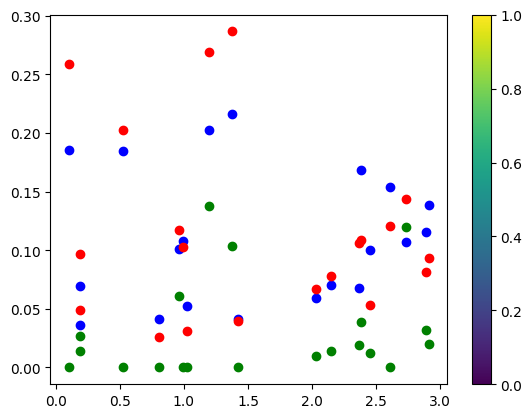

In [12]:
def calculate_interloper_fraction(nz_redshift_samples):

    nint = len(np.where(nz_redshift_samples < 1.5)[0])
    tot = nz_redshift_samples.shape[0]
    return nint/tot

def calculate_highz_fraction(sps_parameter_samples):

    n_high_z = (np.where(sps_parameter_samples[:, 0] > 2.5)[0]).shape[0]
    n_tot = sps_parameter_samples[:, 0].shape[0]

    return n_high_z/n_tot

def calculate_highm_fraction(sps_parameter_samples):
    
    n_high_m = (np.where(sps_parameter_samples[:, -1] > 10**9)[0]).shape[0]
    n_tot = sps_parameter_samples[:, -1].shape[0]

    return n_high_m/n_tot

interloper_fractions = []
hyperparameters = []
highz_fracs = []
highm_fracs = []

ndropouts = 3
colours = ['blue', 'red', 'green']
for dropout in range(ndropouts):
    hyperparameters = []
    interloper_fractions = []
    highz_fracs = []
    highm_fracs = []
    for index in range(nhypersamples):
        interloper_fractions.append(calculate_interloper_fraction(nzs[index][dropout]))
        hyperparameters.append(hyperparameter_samples[index][0][11])# 6, 7, 10, 19  sus?
        highz_fracs.append(calculate_highz_fraction(spsp[index]))
        highm_fracs.append(calculate_highm_fraction(spsp[index]))
    plt.scatter(hyperparameters, interloper_fractions, color=colours[dropout])
    #plt.scatter(highm_fracs, highz_fracs, c=interloper_fractions, cmap='Reds')
    print(interloper_fractions)
plt.colorbar()


In [13]:
np.save("nzs_test4.npy", nzs)
np.save("spsp_test4.npy", spsp)